In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/My\ Drive/adversarial_attacks_DRL

/content/drive/My Drive/adversarial_attacks_DRL


In [3]:
!pip install advertorch
!pip install tianshou

     |████████████████████████████████| 5.7MB 8.4MB/s 
  Created wheel for advertorch: filename=advertorch-0.2.3-cp36-none-any.whl size=5696223 sha256=2d9a534837b1cc3c00dd81255865a89f31be36d6b7c82cdf6778c01a36c111e5
  Stored in directory: /root/.cache/pip/wheels/9b/53/6e/6b2509701b0da68443fa3d4499733f5455d6d583afa8c46676
Successfully built advertorch
     |████████████████████████████████| 92kB 10.2MB/s 
     |████████████████████████████████| 3.1MB 21.8MB/s 
     |████████████████████████████████| 24.6MB 139kB/s 
  Found existing installation: llvmlite 0.31.0
    Uninstalling llvmlite-0.31.0:
      Successfully uninstalled llvmlite-0.31.0
  Found existing installation: numba 0.48.0
    Uninstalling numba-0.48.0:
      Successfully uninstalled numba-0.48.0


In [37]:
from advertorch.attacks import *
from atari_wrapper import wrap_deepmind
import torch
from drl_attacks.uniform_attack import uniform_attack_collector
from drl_attacks.strategically_timed_attack import strategically_timed_attack_collector
from utils import A2CPPONetAdapter
%pylab inline
import matplotlib.pyplot as plt
import numpy as np
import copy

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['copy']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [82]:
from advertorch.attacks.base import Attack
from drl_attacks.base_attack import base_attack_collector
import random as rd
import gym
import time
import torch
import numpy as np
from typing import Any, Dict, List, Union, Optional, Callable
from tianshou.policy import BasePolicy
from tianshou.data import Batch, to_numpy


class targeted_uniform_attack_collector(base_attack_collector):
    """
    :param policy: an instance of the :class:`~tianshou.policy.BasePolicy`
        class.
    :param env: a ``gym.Env`` environment or an instance of the
        :class:`~tianshou.env.BaseVectorEnv` class.
    :param obs_adv_atk: an instance of the :class:`~advertorch.attacks.base.Attack`
        class implementing an image adversarial attack.
    :param perfect_attack: force adversarial attacks on observations to be
        always effective (ignore the ``adv`` param).
    :param atk_frequency: float, how frequently attacking env observations
    """
    def __init__(self,
                 policy: BasePolicy,
                 env: gym.Env,
                 obs_adv_atk: Attack,
                 perfect_attack: bool = False,
                 device: str = 'cuda' if torch.cuda.is_available() else 'cpu',
                 atk_frequency: float = 1.,
                 return_observation = 100
                 ):
        super().__init__(
            policy, env, obs_adv_atk, perfect_attack, device)

        self.return_observation = return_observation
        self.atk_frequency = atk_frequency
        if self.obs_adv_atk is not None:
            self.obs_adv_atk.targeted = True
    
    def obs_attacks(self,
                target_action: Optional[List[int]] = None,
                ):
        """
        Performs an image adversarial attack on the observation stored in 'self.data.obs' respect to
        the action 'target_action' using the method defined in 'self.obs_adv_atk'
        :param target_action:
                - if obs_adv_atk.targeted=False, then 'target_action' must be the normal action.
                - if obs_adv_atk.targeted=True, then 'target_action' must be the adversarial action.
        """
        if not target_action:
            target_action = self.data.act
        obs = torch.FloatTensor(self.data.obs).to(self.device)  # convert observation to tensor
        act = torch.tensor(target_action).to(self.device)  # convert action to tensor
        adv_obs = self.obs_adv_atk.perturb(obs, act)  # create adversarial observation
        with torch.no_grad():
            data = copy.deepcopy(self.data)
            data.obs = adv_obs.cpu().detach().numpy()
            result = self.policy(data, last_state=None)
        self.data.act = to_numpy(result.act)
        return data.obs

    def collect(self,
                n_step: int = 0,
                n_episode: int = 0,
                render: Optional[float] = None
                ) -> Dict[str, float]:
        assert (n_step and not n_episode) or (not n_step and n_episode), \
            "One and only one collection number specification is permitted!"
        self.reset_env()
        self.reset_attack()
        obs_count = 0
        while True:
            if render:
                self.render()
                time.sleep(render)
            self.show_warning()
            self.predict_next_action()

            # START ADVERSARIAL ATTACK
            ori_obs = self.data.obs
            x = rd.uniform(0, 1)
            if x < self.atk_frequency:
                des_act = [rd.randint(0, self.action_space-1)]
                while des_act == self.data.act:
                  des_act = [rd.randint(0, self.action_space-1)]
                if not self.perfect_attack:
                    adv_obs = self.obs_attacks(des_act)
                else:
                    self.data.act = des_act
                if self.data.act == des_act:
                    self.succ_attacks += 1
                self.n_attacks += 1
            self.frames_count += 1
            # END ADVERSARIAL ATTACK

            if x < self.atk_frequency: 
                obs_count += 1
                if obs_count == self.return_observation:
                    return adv_obs, ori_obs

            self.perform_step()
            if self.check_end_attack(n_step, n_episode):
                break

        return self.data.obs, ori_obs

In [7]:
def make_atari_env_watch(env_name):
    return wrap_deepmind(env_name, frame_stack=4,
                         episode_life=False, clip_rewards=False)

In [76]:
def init_attack(env, policy_type="ppo", device="cpu", attack_type="gsm", eps=0.01, targeted=False):
    # load pretrained Pong-PPO policy 
    model_path = "log/" + env + "/" + policy_type + "/policy.pth"
    env = make_atari_env_watch(env)
    state_shape = env.observation_space.shape or env.observation_space.n
    action_shape = env.action_space.shape or env.action_space.n
    policy, _ = torch.load(model_path, map_location=device)
    policy.to(device).init(device)

    # adapt PPO policy to Advertorch library
    if policy_type in ["a2c", "ppo"]:
        adv_net = A2CPPONetAdapter(copy.deepcopy(policy)).to(device)
        adv_net.eval()

    # define image adversarial attack
    if attack_type == "gsm":
        obs_adv_atk = GradientSignAttack(adv_net, eps=eps*255,
                                        clip_min=0, clip_max=255, targeted=targeted)
    elif attack_type == "cw":
        obs_adv_atk = CarliniWagnerL2Attack(adv_net, np.prod(action_shape),
                                            confidence=1, max_iterations=100,
                                            clip_min=0, clip_max=255,
                                            binary_search_steps=8,
                                            targeted=targeted)
    elif attack_type == "pgda":
        obs_adv_atk = PGDAttack(adv_net, eps=eps, targeted=targeted,
                                clip_min=0, clip_max=255, nb_iter=100,
                                eps_iter=0.01)
    return policy, obs_adv_atk

In [83]:
list_env = ["PongNoFrameskip-v4", "BreakoutNoFrameskip-v4", "MsPacmanNoFrameskip-v4",
            "SeaquestNoFrameskip-v4", "QbertNoFrameskip-v4", "EnduroNoFrameskip-v4",
            "SpaceInvadersNoFrameskip-v4"]
list_atk = ["gsm", "cw"]
list_pol = ["a2c", "ppo"]


  
def test_targeted(env, img_atk, policy, eps=0.01, episodes=10):
    device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
    eps = 255*eps
    targeted = True
    policy, obs_adv_atk = init_attack(env, policy_type=policy, device=device, attack_type=img_atk, eps=eps, targeted=targeted)
    env = make_atari_env_watch(env)
    collector = targeted_uniform_attack_collector(policy, env, obs_adv_atk, atk_frequency=0.2, device=device)
    adv_obs, ori_obs = collector.collect(n_episode=episodes)
    return adv_obs, ori_obs

In [99]:
adv_obs, ori_obs = test_targeted("PongNoFrameskip-v4", "gsm", "ppo", eps=0.1)

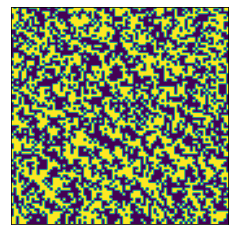

In [100]:
adv_obs = adv_obs[0][0]
plt.xticks([])
plt.yticks([])
plt.imshow(adv_obs/255.)

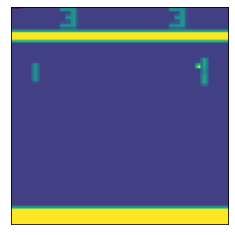

In [104]:
ori_obs = ori_obs[0][0]
plt.xticks([])
plt.yticks([])
plt.imshow(ori_obs/255.)

In [106]:
adv_obs, ori_obs = test_targeted("PongNoFrameskip-v4", "gsm", "ppo", eps=0.01)

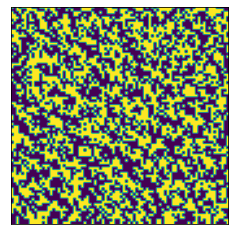

In [107]:
adv_obs = adv_obs[0][0]
plt.xticks([])
plt.yticks([])
plt.imshow(adv_obs/255.)

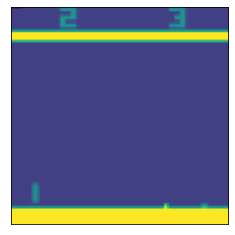

In [108]:
ori_obs = ori_obs[0][0]
plt.xticks([])
plt.yticks([])
plt.imshow(ori_obs/255.)

In [109]:
adv_obs, ori_obs = test_targeted("PongNoFrameskip-v4", "gsm", "ppo", eps=0.001)

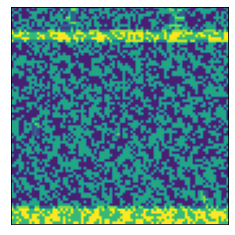

In [110]:
adv_obs = adv_obs[0][0]
plt.xticks([])
plt.yticks([])
plt.imshow(adv_obs/255.)

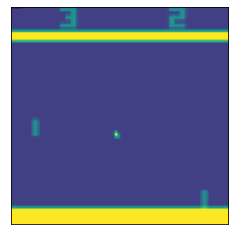

In [111]:
ori_obs = ori_obs[0][0]
plt.xticks([])
plt.yticks([])
plt.imshow(ori_obs/255.)

In [112]:
adv_obs, ori_obs = test_targeted("PongNoFrameskip-v4", "gsm", "ppo", eps=0.0001)

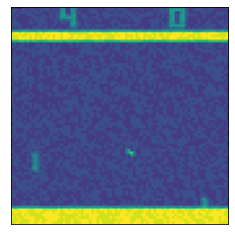

In [113]:
adv_obs = adv_obs[0][0]
plt.xticks([])
plt.yticks([])
plt.imshow(adv_obs/255.)

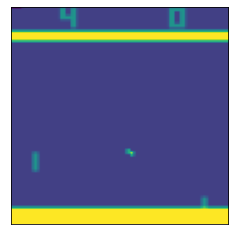

In [114]:
ori_obs = ori_obs[0][0]
plt.xticks([])
plt.yticks([])
plt.imshow(ori_obs/255.)

In [117]:
adv_obs, ori_obs = test_targeted("PongNoFrameskip-v4", "gsm", "ppo", eps=0.00001)

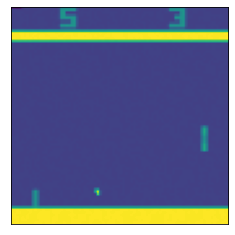

In [118]:
adv_obs = adv_obs[0][0]
plt.xticks([])
plt.yticks([])
plt.imshow(adv_obs/255.)

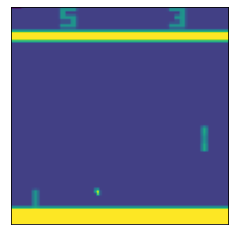

In [119]:
ori_obs = ori_obs[0][0]
plt.xticks([])
plt.yticks([])
plt.imshow(ori_obs/255.)

# PGDA

In [120]:
adv_obs, ori_obs = test_targeted("PongNoFrameskip-v4", "pgda", "ppo", eps=0.1)

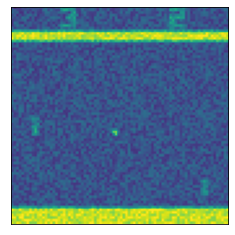

In [121]:
adv_obs = adv_obs[0][0]
plt.xticks([])
plt.yticks([])
plt.imshow(adv_obs/255.)

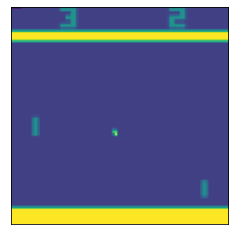

In [122]:
ori_obs = ori_obs[0][0]
plt.xticks([])
plt.yticks([])
plt.imshow(ori_obs/255.)

In [123]:
adv_obs, ori_obs = test_targeted("PongNoFrameskip-v4", "pgda", "ppo", eps=0.01)

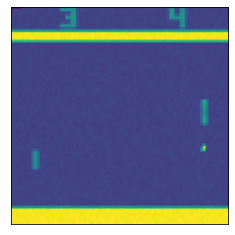

In [124]:
adv_obs = adv_obs[0][0]
plt.xticks([])
plt.yticks([])
plt.imshow(adv_obs/255.)

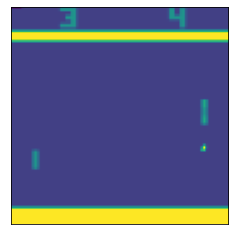

In [125]:
ori_obs = ori_obs[0][0]
plt.xticks([])
plt.yticks([])
plt.imshow(ori_obs/255.)

In [126]:
adv_obs, ori_obs = test_targeted("PongNoFrameskip-v4", "pgda", "ppo", eps=0.001)

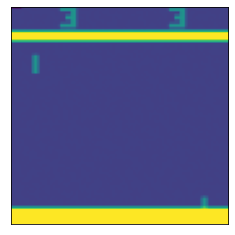

In [127]:
adv_obs = adv_obs[0][0]
plt.xticks([])
plt.yticks([])
plt.imshow(adv_obs/255.)

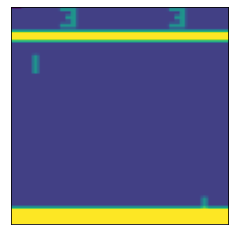

In [128]:
ori_obs = ori_obs[0][0]
plt.xticks([])
plt.yticks([])
plt.imshow(ori_obs/255.)

In [129]:
adv_obs, ori_obs = test_targeted("PongNoFrameskip-v4", "pgda", "ppo", eps=0.0001)

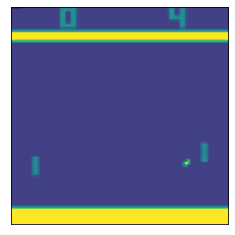

In [130]:
adv_obs = adv_obs[0][0]
plt.xticks([])
plt.yticks([])
plt.imshow(adv_obs/255.)

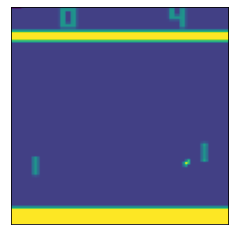

In [131]:
ori_obs = ori_obs[0][0]
plt.xticks([])
plt.yticks([])
plt.imshow(ori_obs/255.)

# CW

In [132]:
adv_obs, ori_obs = test_targeted("PongNoFrameskip-v4", "cw", "ppo")

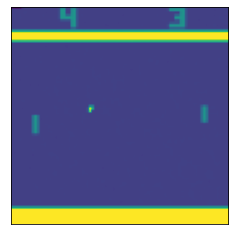

In [133]:
adv_obs = adv_obs[0][0]
plt.xticks([])
plt.yticks([])
plt.imshow(adv_obs/255.)

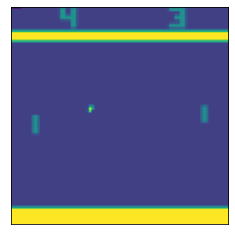

In [134]:
ori_obs = ori_obs[0][0]
plt.xticks([])
plt.yticks([])
plt.imshow(ori_obs/255.)

# Other games PGDA

In [137]:
adv_obs, ori_obs = test_targeted("BreakoutNoFrameskip-v4", "pgda", "ppo", eps=0.01)

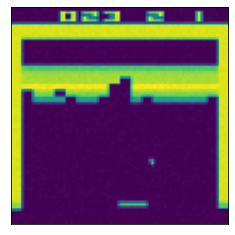

In [138]:
adv_obs = adv_obs[0][0]
plt.xticks([])
plt.yticks([])
plt.imshow(adv_obs/255.)

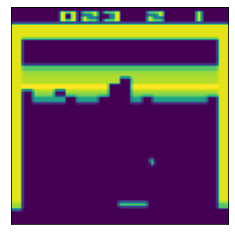

In [139]:
ori_obs = ori_obs[0][0]
plt.xticks([])
plt.yticks([])
plt.imshow(ori_obs/255.)

In [140]:
adv_obs, ori_obs = test_targeted("MsPacmanNoFrameskip-v4", "pgda", "ppo", eps=0.01)

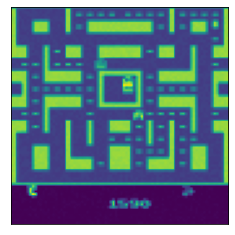

In [141]:
adv_obs = adv_obs[0][0]
plt.xticks([])
plt.yticks([])
plt.imshow(adv_obs/255.)

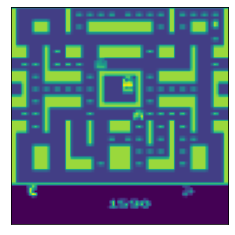

In [142]:
ori_obs = ori_obs[0][0]
plt.xticks([])
plt.yticks([])
plt.imshow(ori_obs/255.)

In [144]:
adv_obs, ori_obs = test_targeted("QbertNoFrameskip-v4", "pgda", "ppo", eps=0.01)

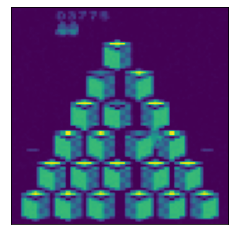

In [145]:
adv_obs = adv_obs[0][0]
plt.xticks([])
plt.yticks([])
plt.imshow(adv_obs/255.)

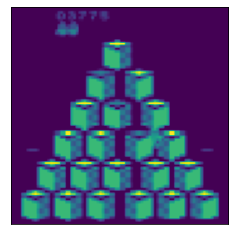

In [146]:
ori_obs = ori_obs[0][0]
plt.xticks([])
plt.yticks([])
plt.imshow(ori_obs/255.)

In [147]:
adv_obs, ori_obs = test_targeted("SeaquestNoFrameskip-v4", "pgda", "ppo", eps=0.01)

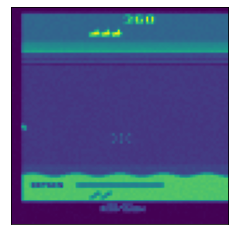

In [148]:
adv_obs = adv_obs[0][0]
plt.xticks([])
plt.yticks([])
plt.imshow(adv_obs/255.)

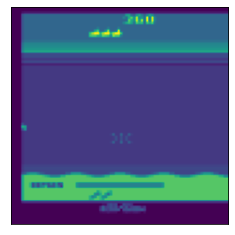

In [149]:
ori_obs = ori_obs[0][0]
plt.xticks([])
plt.yticks([])
plt.imshow(ori_obs/255.)

In [150]:
adv_obs, ori_obs = test_targeted("SpaceInvadersNoFrameskip-v4", "pgda", "ppo", eps=0.01)

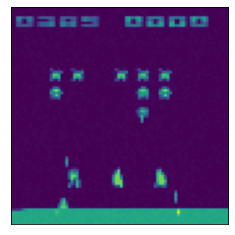

In [151]:
adv_obs = adv_obs[0][0]
plt.xticks([])
plt.yticks([])
plt.imshow(adv_obs/255.)

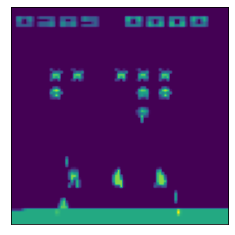

In [152]:
ori_obs = ori_obs[0][0]
plt.xticks([])
plt.yticks([])
plt.imshow(ori_obs/255.)

In [153]:
adv_obs, ori_obs = test_targeted("EnduroNoFrameskip-v4", "pgda", "ppo", eps=0.01)

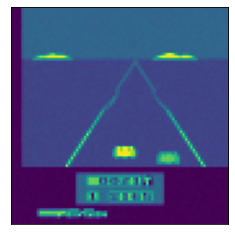

In [154]:
adv_obs = adv_obs[0][0]
plt.xticks([])
plt.yticks([])
plt.imshow(adv_obs/255.)

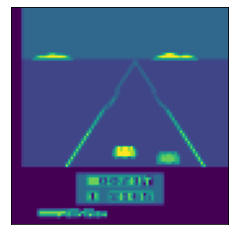

In [155]:
ori_obs = ori_obs[0][0]
plt.xticks([])
plt.yticks([])
plt.imshow(ori_obs/255.)